In [ ]:
import torch
import os

from robopoint.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from robopoint.conversation import conv_templates
from robopoint.model.builder import load_pretrained_model
from robopoint.utils import disable_torch_init
from robopoint.mm_utils import tokenizer_image_token, process_images, get_model_name_from_path

from PIL import Image
import matplotlib.pyplot as plt
import ast
import math

/home/users/kevinma/miniconda3/envs/robopoint/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_path = "wentao-yuan/robopoint-v1-vicuna-v1.5-13b"
model_base = None
load_8bit = True

In [3]:
disable_torch_init()
model_path = os.path.expanduser(model_path)
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, model_base, model_name, load_8bit=load_8bit, device="cuda:1")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]
Some weights of the model checkpoint at wentao-yuan/robopoint-v1-vicuna-v1.5-13b were not used when initializing LlavaLlamaForCausalLM: ['model.vision_tower.vision_tower.vision_model.embeddings.class_embedding', 'model.vision_tower.vision_tower.vision_model.embeddings.patch_embedding.weight', 'model.vision_tower.vision_tower.vision_model.embeddings.position_embedding.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.weight', 'model.vision_tower.vis

In [4]:
def run_model(image, qs, conv_mode="llava_v1", temperature=0.2, top_p=None, num_beams=1):
    if DEFAULT_IMAGE_TOKEN not in qs:
        cur_prompt = qs
        if model.config.mm_use_im_start_end:
            qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
        else:
            qs = DEFAULT_IMAGE_TOKEN + '\n' + qs
    else:
        cur_prompt = qs.split('\n', 1)[1]

    conv = conv_templates[conv_mode].copy()
    conv.append_message(conv.roles[0], cur_prompt)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

    image_tensor = process_images([image], image_processor, model.config)[0]

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor.unsqueeze(0).half().cuda(),
            image_sizes=[image.size],
            do_sample=True if temperature > 0 else False,
            temperature=temperature,
            top_p=top_p,
            num_beams=num_beams,
            # no_repeat_ngram_size=3,
            max_new_tokens=1024,
            use_cache=True)

    outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()

    # print(cur_prompt)
    # print(outputs)

    return outputs

In [11]:
def plot_points(image, outputs, file_name):
    # Load the image
    width, height = image.size

    # String of coordinates
    # coordinates_str = "[(0.1, 0.2), (0.5, 0.6), (0.9, 0.8)]"  # Example string
    coordinates = ast.literal_eval(outputs)  # Convert string to list of tuples

    # Scale coordinates to image dimensions
    scaled_coordinates = [(x * width, y * height) for x, y in coordinates]
    # print(querry)
    # print(scaled_coordinates)

    # Plot the image and points
    plt.imshow(image)
    for x, y in scaled_coordinates:
        plt.scatter(x, y, c='red', s=50)  # Plot each point
    plt.axis('off')  # Hide axes for better visualization
    plt.savefig(f"/home/users/kevinma/cs5478/RoboPoint/datasets/project/{file_name}")
    plt.show()

Find points to place the can gently on the surface of the square table.
[(0.427, 0.533), (0.459, 0.531), (0.400, 0.529)]


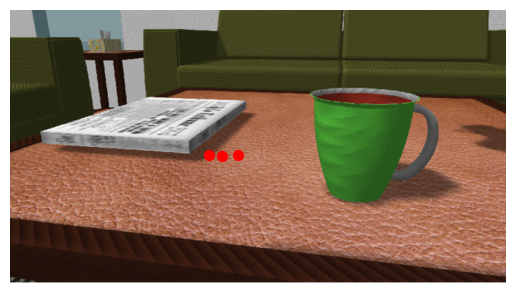

In [ ]:
# Question

# Change the following to locate the input image file
image_folder = "~/cs5478/RoboPoint/datasets"
image_file = "project/step4.png"

prompt_suffix = "Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image."

# Specify the language instruction querry here. This should come from gpt_task_planning
querry = "Find points to place the can gently on the surface of the square table."

image = Image.open(os.path.join(image_folder, image_file)).convert('RGB')
qs = f"{querry} {prompt_suffix}"

outputs = run_model(image, qs)
print(querry)
print(outputs)
plot_points(image, outputs, "step4_out1.png")
